### TFG - Cesar Hernandez Rodriguez
Segundos pasos en las redes neuronales y la bolsa, para este caso buscamos predecir valores y no tendencias

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice nasdaq que es uno de los índices más importantes de Estados Unidos, siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. 

El primer paso será mediante WEB-Scrapping descargar de Wikipedia los tickets de los 500 valores del índice bursatil, después ire recursivamente descargando todos los datos disponibles de los 500 valores desde el 2000 hasta el final del año 2017, estos datos los usare para entrenar la red neuronal y poder predecir el primer trimestre de 2018. La selección de estas fechas se debe al a disponibilidad que ofrece la librería Quandl ya que al usarla de forma gratuita no se puede descargar los históricos de todos los datos ni todo los datos más actuales, de todas formas aún asi vamos a tener problemas ya que solo he conseguido de 485 de 500 activos y de algunos no tenemos unos datos históricos tan extensos como lo que buscabamos.

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

In [1]:
import pandas as pd
import numpy as np
import random
import quandl
from time import time
import pickle
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import model_selection
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from math import *
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
#Tengo dos bases de datos con todos los tickers del indice nasdaq y todos los tickers
# que tiene mi base de datos y extraigo solo los que tengo
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols.csv')['Symbol']
    
    tickersQuandl = []    
    tickers = []
    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq[i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers.append(word)
    
    tickers = random.choices(tickers, k=50)
    
    for tick in tickers:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

# a,b = get_tickers_sample_nasdaq()

In [3]:
# Descargo los datos de la API Quandl, para ello uso el conjunto de datos que me ofrece WIKI/ que se puede ver en la página 
# de la libreria y me registro en la pagina de forma gratuita dandome esa key.
# me devuelve una lista con los datos y con los datos solo de cierre, a parte de guardan los datos serializados en 
# una carpeta llamada datos/
def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    for ticker in tickersQuandl:
        if i % 5 == 0:
            print("LLeva descargados el ",i/long *100,"% de los datos")
        aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
        #print(key, ":", datosClose[key])
    
    elapsed_time = time() - start_time
    print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    print("\n ****Empezamos a descargar los datos test****\n")
    
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 5 == 0:
            print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2016-08-23",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    print("\n")
    
        # Solo cogemos los datos que nos da la aplicacion
    # ya que hay activos que no tenemos su valor en esas fechas o tenemos muy pocos datos
    quitar = []
    for key in tickers:
        if datosClose_test[key].empty:
            if verbose == True : print("Restriccion de vacio",key) 
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
        elif len(datosClose_test[key]) < 300:
            if verbose == True :  print("Restriccion de longitud",key)
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
            
    for key in quitar:
        tickers.remove(key)
    
    pickle.dump(tickers, open("datos/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos/nasdaq_test.p", "wb"))
    pickle.dump(datosClose_test, open("datos/nasdaqClose_test.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [6]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load():
    tickers = pickle.load(open("datos/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos/nasdaqClose.p", "rb" ))
    return tickers, tickersQuandl, datos, datosClose

def get_data_load_test():
    datos = pickle.load(open("datos/nasdaq_test.p", "rb" ))
    datosClose = pickle.load(open("datos/nasdaqClose_test.p", "rb" ))
    return datos, datosClose

# Para imprimir cualquier conjunto de datos descargados, se necesita el conjunto de datosClose sin ser data frame 
# y el ticker de los valores (luego se muestra un ejemplo)
def plot_datos(datosClose,nombre,test):
    datosClose[nombre].plot(figsize=(12,5),grid=True)
    plt.title('{} {}\n'.format(nombre,test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()

In [8]:
datos_descargados = False
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose= get_data_load()
    datos_test, datosClose_test = get_data_load_test()
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a descargar los datos****

LLeva descargados el  0.0 % de los datos
LLeva descargados el  10.0 % de los datos
LLeva descargados el  20.0 % de los datos
LLeva descargados el  30.0 % de los datos
LLeva descargados el  40.0 % de los datos
LLeva descargados el  50.0 % de los datos
LLeva descargados el  60.0 % de los datos
LLeva descargados el  70.0 % de los datos
LLeva descargados el  80.0 % de los datos
LLeva descargados el  90.0 % de los datos

Ha tardado en descargar los datos: 106.3883976936 segundos.

 ****Empezamos a descargar los datos test****

LLeva descargados el  0.0 % de los datos test
LLeva descargados el  10.0 % de los datos test
LLeva descargados el  20.0 % de los datos test
LLeva descargados el  30.0 % de los datos test
LLeva descargados el  40.0 % de los datos test
LLeva descargados el  50.0 % de los datos test
LLeva descargados el  60.0 % de los datos test
LLeva descargados el  70.0 % de los datos test
LLeva descargados el  80.0 % de los datos test
LLeva de

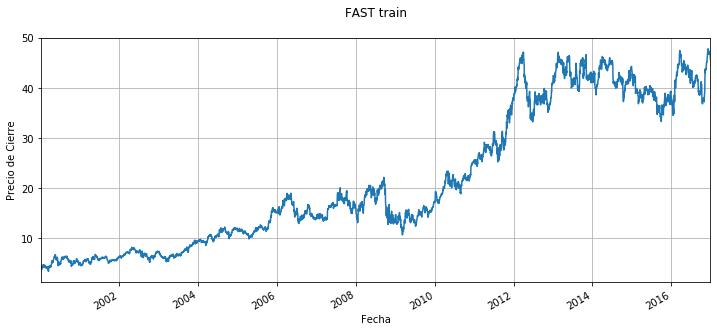

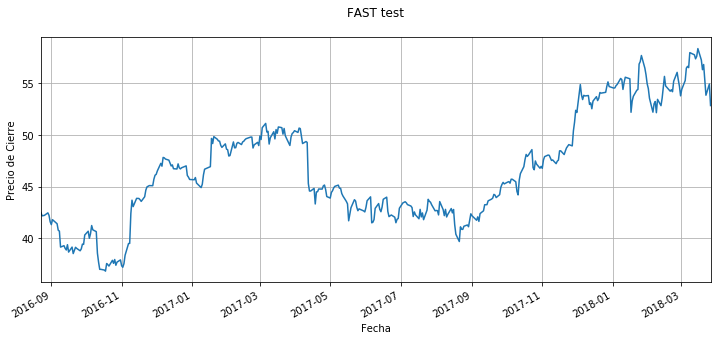

In [9]:
# plot de uno aleatorio
ran = random.randint(0,len(tickers)-1)
plot_datos(datosClose,tickers[ran],"train")
plot_datos(datosClose_test,tickers[ran],"test")

In [16]:
def differences(x):
    return x[-1] - x[0]

# Creamos las variables, aunque podemos meter osciladores o mas medias unicamente
# de momento considero la media movil para sacar la tendencia corta y otra para la tendencia
# larga, como he calculado las tendencias con la media movil de más dias tengo que
# eliminar los primeros \dias datos.
# Añado la variable de variacion de 30 dias de una misma media movil
# Si va yendo bien todo a la hora de hacer esto puedo meter aqui mas atributos, tendre que buscar
# cuales pero que sean restas entre medias moviles, como el momento o la tasa de cambio
def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:(len(X)-1)].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[days2:len(indices)]


In [17]:
index = ran
timeStep = 30

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers[index]],15,30)
Y = pd.DataFrame(datosClose[tickers[index]].values[31:len(datosClose[tickers[index]])])
X = X.to_numpy()

Xt = []
yt = []
index_time = []

for i in range(timeStep, len(X)):
    Xt.append(X[i-timeStep:i,:])
    yt.append(Y.iloc[i,0])
    index_time.append(ind_time[i])


Xt, yt, index_time = np.array(Xt), np.array(yt), pd.Series(index_time)

P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]

# Lo mismo para el conjunto TEST

ticket_uso = tickers[index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers[index]],15,30)
Ytesteo = pd.DataFrame(datosClose_test[tickers[index]].values[31:len(datosClose_test[tickers[index]])])
Xtesteo = Xtesteo.to_numpy()

Xtt = []
ytt = []
index_time_t = []

for i in range(timeStep, len(Xtesteo)):
    Xtt.append(Xtesteo[i-timeStep:i,:])
    ytt.append(Ytesteo.iloc[i,0])
    index_time_t.append(ind_time_t[i])
    
Xtt, ytt, index_time_t = np.array(Xtt), np.array(ytt), pd.Series(index_time_t)
print(ticket_uso)



FAST


In [20]:
# Creacion de la red neural LSTM

model = Sequential()
model.add(LSTM(10, input_shape=(30,3),return_sequences=True))
model.add(LSTM(units = 5,return_sequences = False))
model.add(Dense(1)) 
model.compile(optimizer="adam",loss='mse') 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30, 10)            560       
_________________________________________________________________
lstm_6 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 886
Trainable params: 886
Non-trainable params: 0
_________________________________________________________________


In [21]:
history_LSTM = model.fit(X_train,
                  y_train,
                  epochs=500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Train on 2810 samples, validate on 1406 samples
Epoch 1/500
2810/2810 [==============================] - 6s 2ms/step - loss: 612.2987 - val_loss: 574.3982
Epoch 2/500
2810/2810 [==============================] - 4s 1ms/step - loss: 524.8082 - val_loss: 518.8038
Epoch 3/500
2810/2810 [==============================] - 4s 1ms/step - loss: 487.2790 - val_loss: 493.2993
Epoch 4/500
2810/2810 [==============================] - 4s 1ms/step - loss: 465.7083 - val_loss: 473.2580
Epoch 5/500
2810/2810 [==============================] - 4s 1ms/step - loss: 447.1025 - val_loss: 455.2789
Epoch 6/500
2810/2810 [==============================] - 4s 1ms/step - loss: 430.1002 - val_loss: 438.5908
Epoch 7/500
2810/2810 [==============================] - 4s 1ms/step - loss: 414.3009 - val_loss: 422.9981
Epoch 8/500
2810/2810 [==============================] - 4s 1ms/step - loss: 399.4935 - val_loss: 408.3297
Epoch 9/500
2810/2810 [==============================] - 4s 1ms/step - loss: 385.5726 - val_loss

2810/2810 [==============================] - 4s 1ms/step - loss: 18.5670 - val_loss: 19.2869
Epoch 78/500
2810/2810 [==============================] - 4s 1ms/step - loss: 17.2997 - val_loss: 18.0699
Epoch 79/500
2810/2810 [==============================] - 4s 1ms/step - loss: 16.0833 - val_loss: 16.7374
Epoch 80/500
2810/2810 [==============================] - 4s 1ms/step - loss: 14.9694 - val_loss: 15.6035
Epoch 81/500
2810/2810 [==============================] - 4s 1ms/step - loss: 13.9128 - val_loss: 14.5275
Epoch 82/500
2810/2810 [==============================] - 4s 1ms/step - loss: 12.9546 - val_loss: 13.6425
Epoch 83/500
2810/2810 [==============================] - 4s 1ms/step - loss: 12.0823 - val_loss: 12.6110
Epoch 84/500
2810/2810 [==============================] - 4s 1ms/step - loss: 11.2023 - val_loss: 11.6921
Epoch 85/500
2810/2810 [==============================] - 4s 1ms/step - loss: 10.4417 - val_loss: 10.8952
Epoch 86/500
2810/2810 [==============================] - 4

2810/2810 [==============================] - 4s 1ms/step - loss: 0.6683 - val_loss: 0.8734
Epoch 156/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.7471 - val_loss: 0.5646
Epoch 157/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.6039 - val_loss: 0.6378
Epoch 158/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.6057 - val_loss: 0.6158
Epoch 159/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.6476 - val_loss: 0.5852
Epoch 160/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.6372 - val_loss: 0.5586
Epoch 161/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5667 - val_loss: 0.5263
Epoch 162/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.6086 - val_loss: 0.5312
Epoch 163/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5944 - val_loss: 0.7004
Epoch 164/500
2810/2810 [==============================] - 4s 1ms/ste

2810/2810 [==============================] - 4s 1ms/step - loss: 0.5388 - val_loss: 0.5608
Epoch 234/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5252 - val_loss: 0.5090
Epoch 235/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5873 - val_loss: 0.5299
Epoch 236/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5588 - val_loss: 0.5750
Epoch 237/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5240 - val_loss: 0.5774
Epoch 238/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5300 - val_loss: 0.5117
Epoch 239/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5556 - val_loss: 0.6676
Epoch 240/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5539 - val_loss: 0.5118
Epoch 241/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5199 - val_loss: 0.4794
Epoch 242/500
2810/2810 [==============================] - 4s 1ms/ste

2810/2810 [==============================] - 3s 1ms/step - loss: 0.4871 - val_loss: 0.4916
Epoch 312/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5117 - val_loss: 0.5510
Epoch 313/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5551 - val_loss: 0.4767
Epoch 314/500
2810/2810 [==============================] - 3s 1ms/step - loss: 0.4890 - val_loss: 0.4913
Epoch 315/500
2810/2810 [==============================] - 3s 1ms/step - loss: 0.5011 - val_loss: 0.4803
Epoch 316/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5461 - val_loss: 0.5768
Epoch 317/500
2810/2810 [==============================] - 3s 1ms/step - loss: 0.5156 - val_loss: 0.4918
Epoch 318/500
2810/2810 [==============================] - 3s 1ms/step - loss: 0.5431 - val_loss: 0.4699
Epoch 319/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5200 - val_loss: 0.8714
Epoch 320/500
2810/2810 [==============================] - 4s 1ms/ste

2810/2810 [==============================] - 4s 1ms/step - loss: 0.4760 - val_loss: 0.5033
Epoch 390/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.4810 - val_loss: 0.4642
Epoch 391/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.4990 - val_loss: 0.4768
Epoch 392/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5173 - val_loss: 0.4600
Epoch 393/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5210 - val_loss: 0.5602
Epoch 394/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5143 - val_loss: 0.5619
Epoch 395/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5273 - val_loss: 0.5626
Epoch 396/500
2810/2810 [==============================] - 3s 1ms/step - loss: 0.5027 - val_loss: 0.4650
Epoch 397/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.4943 - val_loss: 0.5490
Epoch 398/500
2810/2810 [==============================] - 4s 1ms/ste

2810/2810 [==============================] - 4s 1ms/step - loss: 0.5154 - val_loss: 0.4806
Epoch 468/500
2810/2810 [==============================] - 3s 1ms/step - loss: 0.5252 - val_loss: 0.5277
Epoch 469/500
2810/2810 [==============================] - 3s 1ms/step - loss: 0.4711 - val_loss: 0.6500
Epoch 470/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5214 - val_loss: 0.4950
Epoch 471/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.4935 - val_loss: 0.4759
Epoch 472/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.4839 - val_loss: 0.5006
Epoch 473/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.4652 - val_loss: 0.5409
Epoch 474/500
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5097 - val_loss: 0.5226
Epoch 475/500
2810/2810 [==============================] - 3s 1ms/step - loss: 0.4908 - val_loss: 0.5639
Epoch 476/500
2810/2810 [==============================] - 4s 1ms/ste

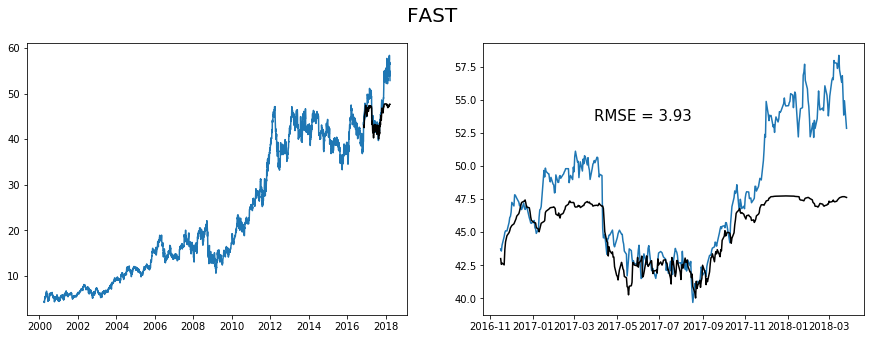

In [22]:
# Calculo la prediccion para mi conjunto test
predicted_stock_price = pd.DataFrame(model.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmse = sqrt(mean_squared_error(ytt, predicted_stock_price))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
fig.suptitle(tickers[index],fontsize = 20)
# Plot de todo el grafico
ax1.plot(indicedetiempo,stock_real_value)
ax1.plot(index_time_t,predicted_stock_price, color = "black")

# Plot de solo la parte que hemos hecho el predict
ax2.plot(index_time_t,ytt)
ax2.plot(index_time_t,predicted_stock_price, color = "black")
ax2.annotate('RMSE = %.2f'% rmse, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

In [19]:
rmse_verdadero = mean_squared_error(ytt, predicted_stock_price)
print(rmse_verdadero)

27.804605422698966
